# Connecting to google drive for faster calculations


In [0]:
import tensorflow as tf
from google.colab import drive
from keras import layers
from keras import Input
from keras.models import Model
from keras.models import load_model
import os
import pandas as pd
import random
import numpy as np
import PIL as pl
import cv2

Using TensorFlow backend.


## Change way to data
### Only need y.npy file

In [0]:
way = '/content/gdrive/My Drive/My Drive/kaggle/sisr/data'

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pwd
os.chdir(way)

/content


# Bicubic preparation

In [0]:
from matplotlib import pyplot as plt

In [0]:
from PIL import Image

def to_bicubic(image, scale):

  width, height = image.shape[1], image.shape[0]
  new_width = int(width * scale)
  new_height = int(height * scale)

  image = Image.fromarray(image.reshape(height, width))
  image = image.resize([new_width, new_height], resample=Image.BICUBIC)
  image = np.asarray(image)
  image = image.reshape(new_height, new_width, 1)

  return image

In [0]:
def get_batch_bicubic(images, scale):
  return np.asarray([to_bicubic(cv2.imread(el), scale) for el in images])

In [0]:
def get_bicubic(images, scale):
  return np.asarray([to_bicubic(pic,scale) for pic in images])

# Data augmentation - flip the images

In [0]:
def get_image_augmentation(image, output):

  image_normal = np.expand_dims(get_split_images(image, output), axis=0)
  image_flip_hor = np.expand_dims(get_split_images(np.flip(image, 0), output), axis= 0)
  image_flip_ver = np.expand_dims(get_split_images(np.flip(image, 1), output), axis= 0)
  image_flip_hor_ver = np.expand_dims(get_split_images(np.flip(np.flip(image,0),1), output), axis=0)

  res = np.concatenate((image_normal,image_flip_hor, image_flip_ver, image_flip_hor_ver), axis=0)

  return res

In [0]:
def get_data_augmentation(images, output):
  return [get_image_augmentation(elem, output) for elem in images]

# Splitting the data into patches


In [0]:
def get_split_images(image, output, window_size=32, stride=16):
    
    if output:
      window_size *= scale
      stride *= scale
    
    if len(image.shape) == 3 and image.shape[2] == 1:
        image = image.reshape(image.shape[0], image.shape[1])

    window_size = int(window_size)
    size = image.itemsize  # byte size of each value
    height, width = image.shape

    if height < window_size or width < window_size:
        return None

    new_height = 1 + (height - window_size) // stride
    new_width = 1 + (width - window_size) // stride

    shape = (new_height, new_width, window_size, window_size)
    strides = size * np.array([width * stride, stride, width, 1])

    windows = np.lib.stride_tricks.as_strided(image, shape=shape, strides=strides)

    windows = windows.reshape(windows.shape[0] * windows.shape[1], windows.shape[2], windows.shape[3], 1)

    return windows

# Important Functions

In [0]:
def shape_normalization(arr):
  res = []
  for elem in arr:
    print(elem[1].shape)
    for i in range(4):
      res.append(elem[i])
  res_np = np.array(res)
  len(res_np)
  
  for i, elem in enumerate(res_np):
    print(i)
    if (i== 0):
      temp = elem
    else:
      res = np.concatenate((temp, elem), axis=0)
      temp = res
  
  return res

In [0]:
def rgb_to_y_image(image):
  
  xform = np.array([[65.738 / 256.0, 129.057 / 256.0, 25.064 / 256.0]])
  y_image = image.dot(xform.T) + 16.0

  return y_image

In [0]:
def get_alignment(images, alignment):
  return [set_image_alignment(el, alignment) for el in images]

In [0]:
def set_image_alignment(image, alignment):
    alignment = int(alignment)
    width, height = image.shape[1], image.shape[0]
    width = (width // alignment) * alignment
    height = (height // alignment) * alignment

    if image.shape[1] != width or image.shape[0] != height:
        image = image[:height, :width, :]

    if len(image.shape) >= 3 and image.shape[2] >= 4:
        image = image[:, :, 0:3]

    return image

# Data uploading and preparation (Don't need to use it. Just upload the y.npy)

In [0]:
# bsd 200 and yang91 for training 
# set 5 for validation
# bsd100 set 14 for test

Creating train dataset

In [0]:
os.chdir(way + '/bsd200')
l1 = os.listdir()
images_BGR_1 = [cv2.imread(elem) for elem in l1]

In [0]:
os.chdir(way + '/yang91')
l2 = os.listdir()
images_BGR_2 = [cv2.imread(elem) for elem in l2]

In [0]:
images_BGR = images_BGR_1 + images_BGR_2

In [0]:
os.chdir(way)
np.save('Images_BGR_Train.npy', images_BGR)

Load train images_BGR

In [0]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
images_BGR = np.load(way + '/Images_BGR_Train.npy')

In [0]:
print(len(images_BGR))

291


In [0]:
y = [rgb_to_y_image(img) for img in images_BGR]

scale = 2
y = get_alignment(y, scale)

x1 = get_bicubic(y, 1.0 / scale)
x2 = get_bicubic(x1, scale)

In [0]:
print(len(x1))

291


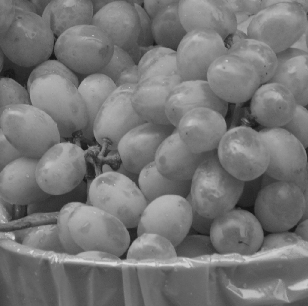

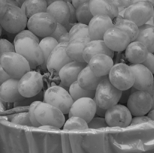

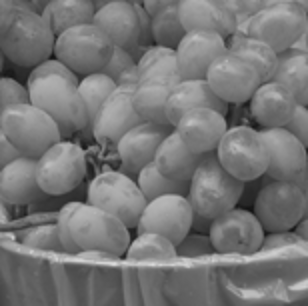

In [0]:
from google.colab.patches import cv2_imshow
cv2_imshow(y[285])
cv2_imshow(x1[285])
cv2_imshow(x2[285])

In [0]:
y_augmented = get_data_augmentation(y, True)
x1_augmented = get_data_augmentation(x1, False)
x2_augmented = get_data_augmentation(x2, True)

print(y_augmented[1][1].shape)
print(x1_augmented[1][1].shape)
print(x2_augmented[1][1].shape)

(126, 64, 64, 1)
(126, 32, 32, 1)
(126, 64, 64, 1)


In [0]:
y_res = shape_normalization(y_augmented)
os.chdir(way)
np.save('y.npy', y_res)

In [0]:
x1_res = shape_normalization(x1_augmented)
os.chdir(way)
np.save('x1.npy', x1_res)

In [0]:
x2_res = shape_normalization(x2_augmented)
os.chdir(way)
np.save('x2.npy', x2_res)

# Load prepared data

In [0]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
y = np.load(way + '/y.npy')


In [0]:
scale = 2
x1 = get_bicubic(y, 1.0 / scale)
x2 = get_bicubic(x1, scale)

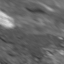

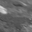

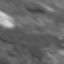

In [0]:
from google.colab.patches import cv2_imshow
cv2_imshow(y[285])
cv2_imshow(x1[285])
cv2_imshow(x2[285])

# Make validation data

(49, 64, 64, 1)
(54, 64, 64, 1)
(49, 64, 64, 1)
(225, 64, 64, 1)
(64, 64, 64, 1)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
(49, 32, 32, 1)
(54, 32, 32, 1)
(49, 32, 32, 1)
(225, 32, 32, 1)
(64, 32, 32, 1)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
(49, 64, 64, 1)
(54, 64, 64, 1)
(49, 64, 64, 1)
(225, 64, 64, 1)
(64, 64, 64, 1)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


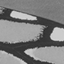

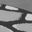

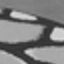

In [0]:
os.chdir(way + '/set5')
l_val = os.listdir()
images_val = [cv2.imread(elem) for elem in l_val]

y_val = [rgb_to_y_image(img) for img in images_val]

scale = 2
y_val = get_alignment(y_val, scale)

x1_val = get_bicubic(y_val, 1.0 / scale)
x2_val = get_bicubic(x1_val, scale)

y_val = get_data_augmentation(y_val, True)
x1_val = get_data_augmentation(x1_val, False)
x2_val = get_data_augmentation(x2_val, True)

y_val =  shape_normalization(y_val)
x1_val = shape_normalization(x1_val)
x2_val = shape_normalization(x2_val)

cv2_imshow(y_val[10])
cv2_imshow(x1_val[10])
cv2_imshow(x2_val[10])

# Network architecture

In [0]:
import tensorflow as tf

In [0]:
from keras import backend as K

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def mean_squared_error_2(y_true, y_pred):

    y_true=K.cast(y_true, dtype='float32')
    y_pred=K.cast(y_pred, dtype='float32')
    
    d=K.cast((y_pred - y_true),dtype='float32')
    loss = K.mean(K.square(d), axis=-1)
 
    return K.sum(loss)

def mean(y_true, y_pred):

  y_true=K.cast(y_true, dtype='float32')
  return K.mean(y_true, axis= -1)

In [0]:
from keras import optimizers
rms_prop = optimizers.RMSprop(lr=0.0000000000001)

In [0]:
from keras import losses

def sisr_architecture(show = True):
  
  list_to_concatenate = []
  
  images = Input(shape = (32, 32, 1))

  bicubic = Input(shape = (64, 64, 1))

  x1 = layers.Conv2D(filters= 96, kernel_size= 3, padding= 'same', input_shape= (32,32,1))(images)
  x1 = layers.LeakyReLU()(x1)
  list_to_concatenate.append(x1)

  x2 = layers.Conv2D(filters= 76, kernel_size= 3, padding= 'same')(x1)
  x2 = layers.LeakyReLU()(x2)
  list_to_concatenate.append(x2)

  x3 = layers.Conv2D(filters= 65, kernel_size= 3, padding= 'same')(x2)
  x3 = layers.LeakyReLU()(x3)
  list_to_concatenate.append(x3)

  x4 = layers.Conv2D(filters= 55, kernel_size= 3, padding= 'same')(x3)
  x4 = layers.LeakyReLU()(x4)
  list_to_concatenate.append(x4)

  x5 = layers.Conv2D(filters= 47, kernel_size= 3, padding= 'same')(x4)
  x5 = layers.LeakyReLU()(x5)
  list_to_concatenate.append(x5)

  x6 = layers.Conv2D(filters= 39, kernel_size= 3, padding= 'same')(x5)
  x6 = layers.LeakyReLU()(x6)
  list_to_concatenate.append(x6)

  x7 = layers.Conv2D(filters= 32, kernel_size= 3, padding= 'same')(x6)
  x7 = layers.LeakyReLU()(x7)
  list_to_concatenate.append(x7)

  conc_1 = layers.concatenate(list_to_concatenate)
  # where to put this list
  list_to_concatenate_2 = []

  a1 = layers.Conv2D(filters= 64, kernel_size= 1, padding= 'same')(conc_1)
  a1 = layers.LeakyReLU()(a1)
  list_to_concatenate_2.append(a1)

  b1 = layers.Conv2D(filters= 32, kernel_size= 1, padding= 'same')(conc_1)
  b1 = layers.LeakyReLU()(b1)

  b2 = layers.Conv2D(filters= 32, kernel_size= 3, padding= 'same')(b1)
  b2 = layers.LeakyReLU()(b2)
  list_to_concatenate_2.append(b2)

  conc_2 = layers.concatenate(list_to_concatenate_2)

  conv = layers.Conv2D(filters= 4, kernel_size= 1, padding= 'same')(conc_2)
  
  conv = layers.Reshape((64,64,1))(conv)

  y_pred = layers.Add()([conv, bicubic])

  model = Model(inputs= [images, bicubic], outputs= y_pred)

  model.compile(optimizer=rms_prop,
              loss=mean_squared_error_2,
              metrics=[mean_squared_error_2]) 
  return model

In [0]:
from keras.callbacks import ModelCheckpoint
epochs = 10
batch_size = 64
model = sisr_architecture()
history = model.fit(x = [x1, x2], 
                    y= y, 
                    validation_data= ([x1_val, x2_val], y_val), 
                    epochs=epochs, 
                    batch_size=batch_size)

Train on 114344 samples, validate on 1764 samples
Epoch 1/10
114344/114344 [==============================] - 55s 479us/step - loss: nan - mean_squared_error_2: nan - val_loss: nan - val_mean_squared_error_2: nan
Epoch 2/10
114344/114344 [==============================] - 54s 474us/step - loss: nan - mean_squared_error_2: nan - val_loss: nan - val_mean_squared_error_2: nan
Epoch 3/10
114344/114344 [==============================] - 54s 476us/step - loss: nan - mean_squared_error_2: nan - val_loss: nan - val_mean_squared_error_2: nan
Epoch 4/10
114344/114344 [==============================] - 54s 474us/step - loss: nan - mean_squared_error_2: nan - val_loss: nan - val_mean_squared_error_2: nan
Epoch 5/10
114344/114344 [==============================] - 54s 475us/step - loss: nan - mean_squared_error_2: nan - val_loss: nan - val_mean_squared_error_2: nan
Epoch 6/10
114344/114344 [==============================] - 54s 474us/step - loss: nan - mean_squared_error_2: nan - val_loss: nan - va

27
(1, 32, 32, 1)


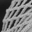

(1, 64, 64, 1)


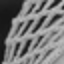

In [0]:
from keras import models

print(len(model.layers))
layer_outputs = [layer.output for layer in model.layers][1:15]

activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
im_1 = np.expand_dims(x1_val[0], axis=0)
print(im_1.shape)
cv2_imshow(im_1[0])
im_2 = np.expand_dims(x2_val[0], axis=0)
print(im_2.shape)
cv2_imshow(im_2[0])
activations = activation_model.predict(x = [im_1, im_2])

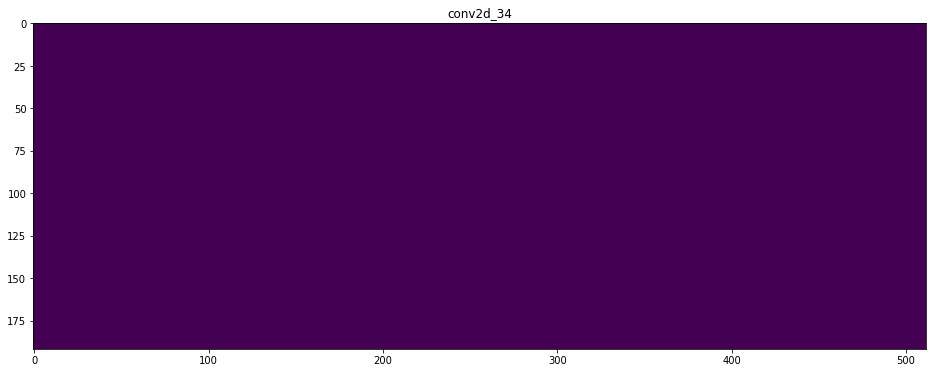

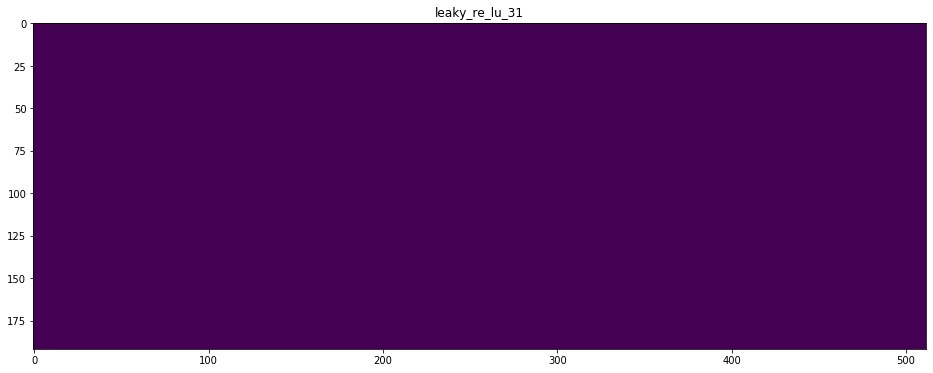

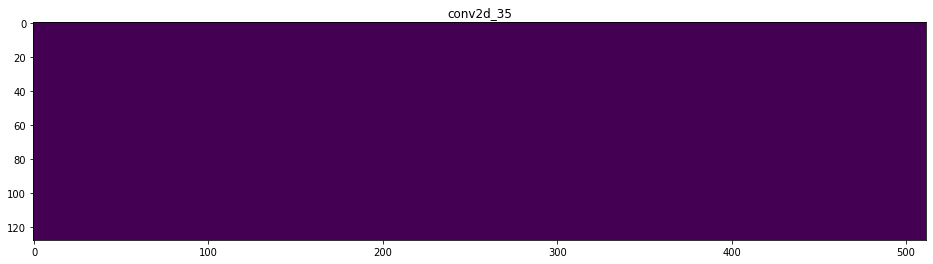

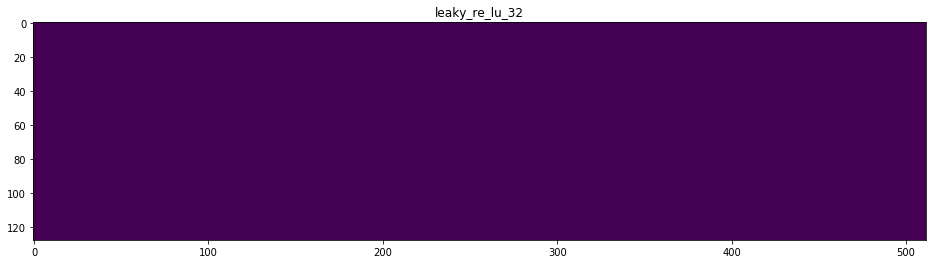

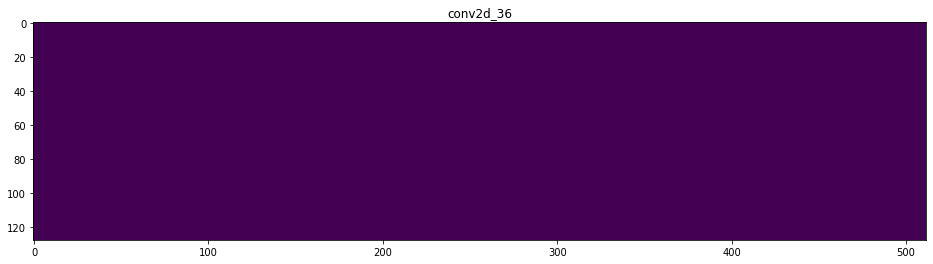

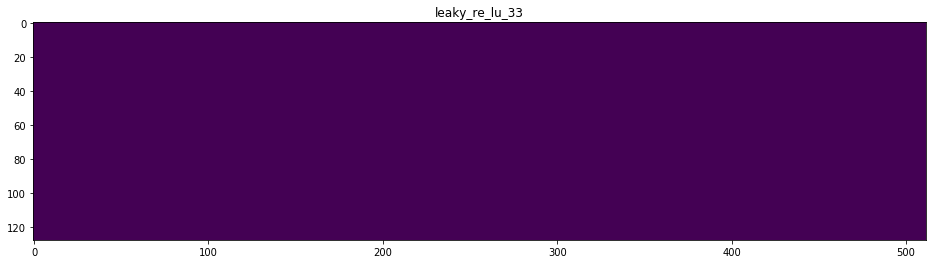

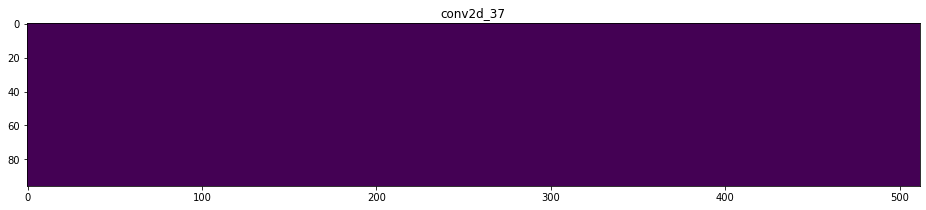

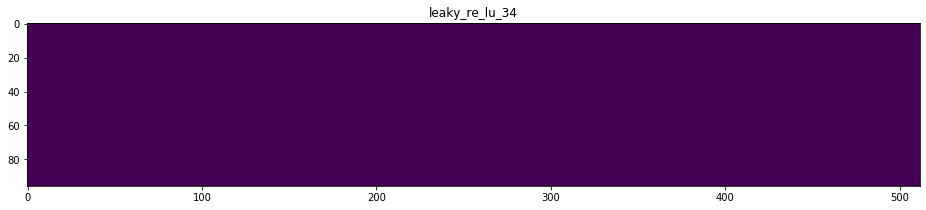

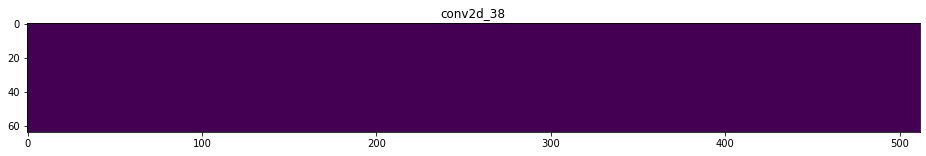

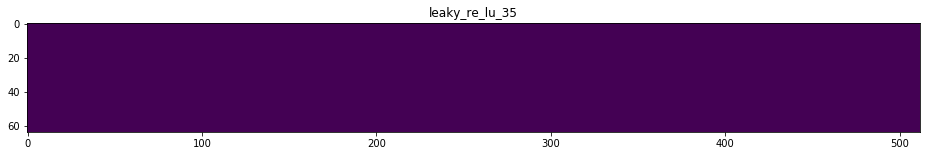

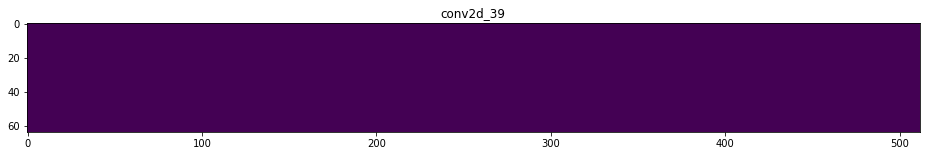

In [0]:
layer_names = []
for layer in model.layers[1:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')